In [21]:
import snapatac2 as snap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import polars as pl
import seaborn as sns
from matplotlib import rc_context

from sklearn import preprocessing
import os
import scipy
from scipy.sparse import csr_matrix
from adjustText import adjust_text

In [2]:
snap.__version__

'2.8.0'

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"    
    elif pvalue <= 0.05:
        return "*"
    return ""
def convert_FDR_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "****"
    elif pvalue <= 0.01:
        return "***"
    elif pvalue <= 0.05:
        return "**"    
    elif pvalue <= 0.1:
        return "*"
    return ""

In [5]:
from scipy import stats
from statsmodels.stats import multitest
def test_sig(x, y):
    if stats.shapiro(x).pvalue >= 0.05 and stats.shapiro(y).pvalue >= 0.05: #if they are normally distriuted
        print("t-test")
        return stats.ttest_ind(x,y)
    else:
        print("mann-whitney")
        return stats.mannwhitneyu(x, y)
def test_mannwhit(x, y):
    return stats.mannwhitneyu(x, y)
def test_ttest_paired(x, y):
    return stats.ttest_rel(x, y)
def test_ttest_unpaired(x, y):
    return stats.ttest_ind(x, y)
def test_fdr(x):
     return multitest.fdrcorrection(x, alpha=0.05, method='indep', is_sorted=False)

def test_ranksums(x, y):
    return stats.ranksums(x, y)

def test_levene(x,y):
     return stats.levene(x, y, center='median', proportiontocut=0.05)

# Chromvar Analysis

In [9]:
# Read chromvar_output
data = pd.read_csv('chromvar_output_adjusted.csv')

In [6]:
# Read the ATAC-seq data (iterative generated Peak-Cell matrix) or any-rnaseq data for metadata only
atac_peak = snap.read('atac-seq_iterative.h5ad', backed=None)

In [10]:
data.iloc[:,0] = data.iloc[:,0].str.replace('.','-')
data.index=data.iloc[:,0]
data.drop(columns='Unnamed: 0', inplace=True)
data = data.dropna(axis=1)

In [14]:
adata = sc.AnnData(csr_matrix(data))

In [15]:
adata.obs = pd.DataFrame(index=data.index.values)  # Sample names as obs
adata.var = pd.DataFrame(index=data.columns.values)    # Gene names as var

In [17]:
adata = adata[atac_peak.obs_names,:]

In [19]:
adata.obs = adata.obs.copy()
adata.obs['new_subset_annotations'] = atac_peak.obs['new_subset_annotations'].values
adata.obs['visit'] = atac_peak.obs['visit'].values
adata.obs['vaccine_visit'] = atac_peak.obs['vaccine_visit'].values
adata.obs['vaccine_person_visit'] = atac_peak.obs['vaccine_person_visit'].values
adata.obs['person'] = atac_peak.obs['person'].values
adata.obs['Vaccine'] = atac_peak.obs['Vaccine'].values

# Volcano Plots

In [22]:
adata

AnnData object with n_obs × n_vars = 34640 × 1438
    obs: 'new_subset_annotations', 'visit', 'vaccine_visit', 'vaccine_person_visit', 'person', 'Vaccine'

In [24]:
import scipy
pvalues = dict()
fdrvalues = dict()
levene = dict()
x_values = adata.obs["vaccine_visit"].unique()

final_df=[]
for x in adata.obs['Vaccine'].unique():
    temp_data = adata[adata.obs["Vaccine"] == x]
    for k in temp_data.obs["vaccine_visit"].unique():
        temp_pvalue=[]
        temp_df = temp_data[temp_data.obs["vaccine_visit"] == k].to_df()
        baseline_df = temp_data[temp_data.obs["vaccine_visit"].str.contains('Baseline_1')].to_df()
        for i in adata.var_names:
            if 'Baseline_1' not in k:
                stat, pvalue = test_ranksums(
                        temp_df.loc[:,i].values,
                        baseline_df.loc[:,i].values
                        )
                temp_pvalue.append([i,pvalue])
            else:
                temp_pvalue.append([i,1])

        
        print(k)
        final_df.append(pd.DataFrame(temp_pvalue).set_index(0).rename(columns={1:k}).T)
          

Pfizer_Baseline_1
Pfizer_Vac2_Baseline
Pfizer_Vac2_D1
Pfizer_Vac1_D1
Pfizer_Vac2_D7
Moderna_Vac2_D7
Moderna_Vac2_Baseline
Moderna_Vac1_D1
Moderna_Baseline_1
Moderna_Vac2_D1
J&J_Vac1_D1
J&J_Vac1_D7
J&J_Baseline_1


In [25]:
pv_data = pd.concat(final_df)
pv_data = pv_data.replace(0,10**-292).T

In [26]:
fdrvalues = dict()
for i in pv_data.columns:
    fdrvalues[i] = test_fdr(pv_data[i])[1]

fdr_data = pd.DataFrame.from_dict(fdrvalues)
fdr_data.index = adata.var_names

In [28]:
df = sc.get.obs_df(adata, [*adata.var_names, 'vaccine_visit'])
heat_last = df.groupby(['vaccine_visit']).mean().T

In [32]:
import scipy
diff_ztemp = dict()
x_values = heat_last.columns
for x in x_values:
    if 'Pfizer' in x and x != 'Pfizer_Baseline_1':

        diff_ztemp[x] = heat_last[x] - heat_last['Pfizer_Baseline_1']
        
    elif 'Moderna' in x and x != 'Moderna_Baseline_1':
        
        diff_ztemp[x] = heat_last[x] - heat_last['Moderna_Baseline_1']

    elif 'J&J' in x and x != 'J&J_Baseline_1':
        
        diff_ztemp[x] = heat_last[x] - heat_last['J&J_Baseline_1']
diff_z = pd.DataFrame.from_dict(diff_ztemp)

In [33]:
diff_z = pd.DataFrame.from_dict(diff_ztemp)

In [34]:
for i in diff_z.index:
    diff_z.loc[i,'diff'] = diff_z.loc[i,:][diff_z.loc[i,:] > 0].abs().sum()
    diff_z.loc[i,'diff'] = diff_z.loc[i,:][diff_z.loc[i,:] < 0].abs().sum()
diff_z['gene_name'] = pd.DataFrame(diff_z.index)[0].str.split('.',expand=True)[0].values

In [35]:
diff_z_ver0 = diff_z.iloc[:,:-2]
fdr_data_ver0 = fdr_data.loc[diff_z_ver0.index,diff_z_ver0.columns]

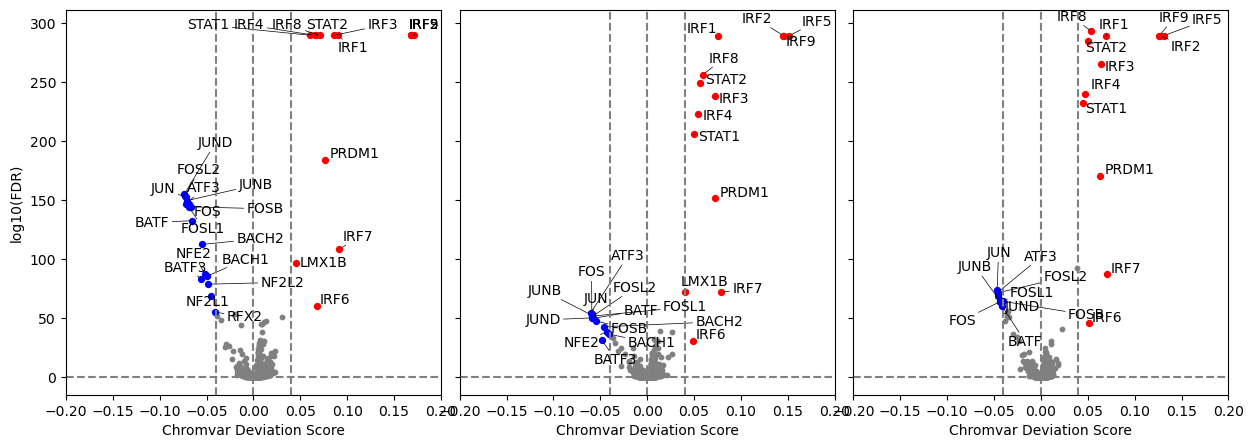

In [36]:
thresh= 0.04
rightup_list=[]
lefttup_list=[]
# offset = 1e-8
offset = 0 
p_thresh = -np.log10(0.05 + offset)

x_max = 0.2
x_min = -0.2

fig, ax = plt.subplots(1,3,figsize=[15,5],
                       sharey=True,
                       sharex=True
                      )
axes = ax.ravel()

time_point = ['J&J_Vac1_D1', 'Moderna_Vac2_D1', 'Pfizer_Vac2_D1']

select_motif = diff_z_ver0.loc[(diff_z_ver0[time_point].abs() > thresh).any(axis=1),time_point].copy()

select_motif['mean'] = select_motif.mean(axis=1).abs()
select_motif['gene_name'] = pd.DataFrame(select_motif.index)[0].str.split('.',expand=True)[0].values
select_motif['motif_no'] = pd.DataFrame(select_motif.index)[0].str.split('.',expand=True)[2].values
exclude_motif=[]
for i in select_motif['gene_name'].unique():
    temp_motif = select_motif[select_motif['gene_name'] == i][['mean','gene_name','motif_no']]
    if ((temp_motif['motif_no'] == '0').sum() == 1) & (len(temp_motif) > 1):
        exclude_motif.append(temp_motif[temp_motif['motif_no'] != '0'].index.tolist())
    elif ((temp_motif['motif_no'] == '0').sum() == 0) & (len(temp_motif) > 1):
        print(temp_motif)
        exclude_motif.append(temp_motif.sort_values('mean', ascending=False).index[1])
    else:
        continue

exclude_motif_flat = [item for sublist in exclude_motif for item in sublist]

exclude_non = diff_z_ver0.loc[(diff_z_ver0[time_point].abs() < thresh).all(axis=1),time_point].copy() # exclude non significant non promary motif from homococo
exclude_non['gene_name'] = pd.DataFrame(exclude_non.index)[0].str.split('.',expand=True)[0].values
exclude_non['motif_no'] = pd.DataFrame(exclude_non.index)[0].str.split('.',expand=True)[2].values


diff_z_ver0 = diff_z_ver0[~(diff_z_ver0.index.isin(exclude_motif_flat + 
                                                   exclude_non[exclude_non['motif_no'] != '0'].index.tolist()))] # exclude based on two condition


k=0
for i in time_point:
    
    pop1 = i    
    plot_data = pd.concat([diff_z_ver0[i], fdr_data_ver0[i]], axis=1)
    plot_data.columns= ['diff', 'pval']
    plot_data = plot_data.astype(float)
    plot_data['diff_abs'] = plot_data['diff'].abs()

    plot_data['gene_name'] = pd.DataFrame(plot_data.index)[0].str.split('.',expand=True)[0].values
    
    mark_up = plot_data[(plot_data['diff'] > thresh) & (-np.log10(plot_data['pval'] + offset) > p_thresh)]
    mark_down = plot_data[(plot_data['diff'] < -thresh) & (-np.log10(plot_data['pval'] + offset) > p_thresh)]
    
    rightup = plot_data[(plot_data['diff'] > thresh)& (-np.log10(plot_data['pval'] + offset) > p_thresh)]
    rightdown = plot_data[(plot_data['diff'] > thresh) & (-np.log10(plot_data['pval'] + offset) < p_thresh)]
    leftup = plot_data[(plot_data['diff'] < -thresh) & (-np.log10(plot_data['pval'] + offset) > p_thresh)]
    leftdown = plot_data[(plot_data['diff'] < -thresh) & (-np.log10(plot_data['pval'] + offset) < p_thresh)]
    remaining = plot_data[~plot_data.index.isin(list(leftup.index.values) + list(rightup.index.values))]
    
    axes[k].scatter(x=rightup['diff'],
                    y=-np.log10(rightup['pval'] + offset),
                    s=18,
                    color="red")
    
    axes[k].scatter(x=remaining['diff'],y=-np.log10(remaining['pval'] + offset),s=10,color="gray")
    axes[k].scatter(x=leftup['diff'],y=-np.log10(leftup['pval'] + offset),s=18,color="blue")
    
    axes[k].set_xlim([x_min,x_max])

    rightup_list.append(rightup.index)
    lefttup_list.append(leftup.index)
    
    texts1=[]
    texts2=[]
    for r in mark_up.index[:]:
        #print(a)
        t = axes[k].text(x=mark_up.loc[r,'diff'],y=-np.log10(mark_up.loc[r,'pval'] + offset),s=r.split('.')[0])
        texts1.append(t)

    for r in mark_down.index[:]:
        #print(a)
        t = axes[k].text(x=mark_down.loc[r,'diff'],y=-np.log10(mark_down.loc[r,'pval'] + offset),s=r.split('.')[0])
        texts2.append(t)

    adjust_text(texts1, arrowprops=dict(arrowstyle="-", color='k', lw=0.5),time_lim=6, force_text=(0.5, 0.5),expand=(1, 1),ax=axes[k])
    adjust_text(texts2, arrowprops=dict(arrowstyle="-", color='k', lw=0.5),time_lim=6, force_text=(0.5, 0.5),expand=(1, 1),ax=axes[k])
    
    axes[k].axvline(0,color="grey",linestyle="--")
    axes[k].axhline(0,color="grey",linestyle="--")

    axes[k].axvline(thresh,color="grey",linestyle="--")
    axes[k].axvline(-thresh,color="grey",linestyle="--")
    
    axes[0].set_ylabel("log10(FDR)")
    axes[k].set_xlabel("Chromvar Deviation Score")

    k += 1
plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Longitudual Heatmap

In [39]:
# Example of chromvar genes
chromvar_gene = [
                 'IRF1.H12CORE.0.P.B',
                 'IRF2.H12CORE.0.PSM.A',
                 'IRF3.H12CORE.0.PS.A',
                 'IRF4.H12CORE.0.P.B',
                 'IRF5.H12CORE.0.SM.B',
                 'IRF6.H12CORE.0.SM.B',
                 'IRF7.H12CORE.0.S.B',
                 'IRF8.H12CORE.0.P.B',
                 'IRF9.H12CORE.0.PSM.A',
                 'LMX1B.H12CORE.0.P.C',
                 'PRDM1.H12CORE.0.S.B',
                 'STAT1.H12CORE.1.P.B',
                 'STAT2.H12CORE.0.P.B',
                ]

In [42]:
df = sc.get.obs_df(adata, [*chromvar_gene, 'vaccine_person_visit'])
dfm = df.groupby(['vaccine_person_visit']).mean().T

In [48]:
dfm_long = dfm[ [ col for col in dfm.columns if 'Baseline_1' in col] + 
    [ col for col in dfm.columns if 'Vac1_D1' in col] + [col for col in dfm.columns if 'Vac1_D7' in col] \
     + [col for col in dfm.columns if 'Vac2_Baseline' in col] + [col for col in dfm.columns if 'Vac2_D1' in col] \
     + [col for col in dfm.columns if 'Vac2_D7' in col]]

dfm_long = dfm_long[ [ col for col in dfm_long.columns if 'J&J' in col] + 
    [ col for col in dfm_long.columns if 'Moderna' in col] + 
    [ col for col in dfm_long.columns if 'Pfizer' in col]] 

In [49]:
dfm_long.index = pd.DataFrame(dfm_long.index)[0].str.split('.',expand=True)[0]

In [50]:
print(dfm_long.max().max(),dfm_long.min().min())

0.1271361775427504 -0.11031233993881091


In [51]:
col_cmap_jj = ['#006400'] * 3 + ['#32CD32'] * 3 + ['#90EE90'] * 3
col_cmap_moderna = ['#000080'] * 6 + ['#0000CD'] * 6 + ['#4169E1'] * 6  + ['#1E90FF'] * 6 + ['#87CEEB'] * 6 
col_cmap_pfizer =  ['#8B0000'] * 6 + ['#B22222'] * 6 + ['#DC143C'] * 6  + ['#CD5C5C'] * 6 + ['#FF6347'] * 6 

col_cmap_combined=col_cmap_jj+col_cmap_moderna+col_cmap_pfizer

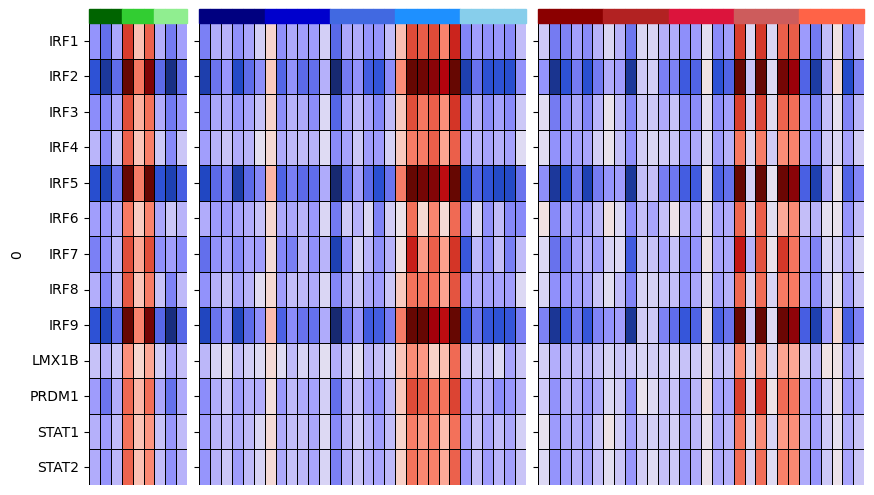

In [55]:
# Per donor level

from itertools import product
import colorcet as cc
fig, ax = plt.subplots(1,3,figsize=(10, 6), sharey=False, gridspec_kw={'width_ratios': [9, 30, 30]})
axs = ax.ravel()

max_val = 0.1
min_val = -0.1

key=[range(0,9), range(9,39), range(39,69)]

ax_count = 0
for i in key:
    g = sns.heatmap(dfm_long.iloc[:,i],
                    center=0,
                    cmap=cc.CET_D1A,
                    vmin=min_val,
                    vmax=max_val,
                    ax=axs[ax_count],
                    # yticklabels=False,
                    xticklabels=False,
                    cbar=None,
                    linewidths=0.5,
                    linecolor="black"
          )

    ax[ax_count].set_xlabel('')

    if ax_count!=0:
        ax[ax_count].set_ylabel('')
        g.set_yticklabels('', rotation=0) 
    
    axs[ax_count].tick_params(axis='x', which='major', pad=5, length=10) 
    for x_ax, color in enumerate(col_cmap_combined[i[0]:i[-1]+1]):
        axs[ax_count].add_patch(plt.Rectangle(xy=(x_ax, 1), width=1, height=0.03, color=color, lw=1,
                                   transform=axs[ax_count].get_xaxis_transform(), clip_on=False))

    
    ax_count += 1

plt.subplots_adjust(wspace=0.05, hspace=0.1) 


# RNA-TF HEATMAP

In [203]:
# In study only TF with showing high correlation wtih ATAC-RNAseq data included

In [111]:
gene_names = pd.DataFrame(chromvar_gene)[0].str.split('.',expand=True)[0].values

In [112]:
gene_names[gene_names == 'NF2L2'] =  'NFE2L2'
gene_names[gene_names == 'NF2L1'] =  'NFE2L1'

In [115]:
genedf = sc.get.obs_df(rna_data, keys=["vaccine_visit", *gene_names], use_raw=True)
dfm_rna = genedf.groupby("vaccine_visit", observed=True).mean().T

In [194]:
rna_data

View of AnnData object with n_obs × n_vars = 53741 × 1490
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'run_number', 'library', 'person_visit', 'person', 'visit', 'SUBJECT ID', 'Vaccine', 'Sex', 'Age', 'baseline_titer', 'final_titer', 'fold_change', 'Visit', 'pool', 'set', 'barcode', 'leiden_060', 'leiden_100', 'leiden_080', 'new_subset_annotations', 'new_subset_annotations_1', 'is_cv', 'new_subset_annotations_2', 'celltypes', 'vaccine_person', 'vaccine_visit', 'vaccine_person_visit', 'isg_sub_donor', 'isg_sub_vac', 'isg_sub_vac_donor', 'isg_vac_donor_visit'
    var: 'highly_variable', 'is_protein', 'is_rna', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Vaccine_colors', 'celltypes_colors', 'hvg', 'leiden', 'neighbors', 'new_subset_annotations_1_colors', 'new_subset_annotations_2_colors', 'new_subset_annotations_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    va

In [201]:
def significant_cal_cell(adata, group, baseline_name, all_col_names, vaccine, genes):
    res=[]
    pvalues = dict()
    fdrvalues = dict()

    adata = adata.raw.to_adata()[adata.raw.to_adata().obs[group].str.contains(vaccine),genes]

    df = sc.get.obs_df(adata, keys=[group, *genes])
    dfm = df.groupby(group).mean().T
    # print(dfm)
    baseline = dfm[[i for i in dfm.columns if baseline_name in i]].T
    # print(baseline)
    baseline.index = pd.DataFrame(baseline.index)[group].str.rsplit('_',expand=True)[1]
    
    for i in x_values:    
        if (adata.obs[group].str.contains(i)).any():

            temp = dfm[[k for k in dfm.columns if i in k]].T
            temp.index = pd.DataFrame(temp.index)[group].str.split('_',expand=True)[1]
            temp_pvalue=[]
            if temp.shape[0] > 0:
                for f in temp.columns:
                    if baseline_name not in i:
                        stat, pvalue = scipy.stats.ttest_rel(  
                            temp.loc[baseline.index,f].values.astype(float),
                            baseline.loc[:,f].values.astype(float),
                            alternative='greater'
                            )
                        # print(pvalue)
                        temp_pvalue.append(pvalue)
                        pass
                    else:
                        temp_pvalue.append(1)
                        pass
                    pvalues[i] = temp_pvalue

    pv_data = pd.DataFrame.from_dict(pvalues)
    pv_data.index = adata.var_names
    
    return pv_data

In [196]:
x_values = ['Baseline_1','Vac1_D1', 'Vac1_D7','Vac2_Baseline', 'Vac2_D1','Vac2_D7']

adeno_rna_pvalue = significant_cal_cell(rna_data, 'vaccine_person_visit', 'Baseline_1', x_values, 'J&J', gene_names)
moderna_rna_pvalue = significant_cal_cell(rna_data, 'vaccine_person_visit', 'Baseline_1', x_values, 'Moderna', gene_names)
pfizer_rna_pvalue = significant_cal_cell(rna_data, 'vaccine_person_visit', 'Baseline_1', x_values, 'Pfizer', gene_names)

In [197]:
adeno_rna_pvalue.columns = adeno_rna_pvalue.columns + '_J&J'
moderna_rna_pvalue.columns = moderna_rna_pvalue.columns + '_Moderna'
pfizer_rna_pvalue.columns = pfizer_rna_pvalue.columns + '_Pfizer'
rna_pvalue = pd.concat([adeno_rna_pvalue,moderna_rna_pvalue,pfizer_rna_pvalue], axis=1)

In [198]:
from scipy.stats import zscore
dfm_rna_zscores = dfm_rna.apply(zscore, axis=1)

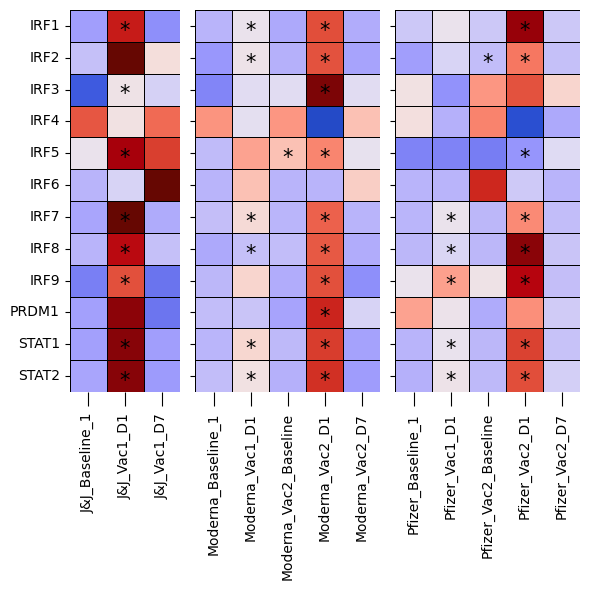

In [204]:
from itertools import product
import colorcet as cc
fig, ax = plt.subplots(1,3,figsize=(6, 6), sharey=False, gridspec_kw={'width_ratios': [3, 5, 5]})
axs = ax.ravel()

min_val = -2.5
max_val = 2.5

key=[range(0,3), range(3,8), range(8,13)]

ax_count = 0
for i in key:
    if ax_count!=2:
        cbar_label=None
    else:
        cbar_label=True
        
    g = sns.heatmap(
                    dfm_rna_zscores.iloc[:,i],
                    center=0,
                    cmap=cc.CET_D1A,
                    vmin=min_val,
                    vmax=max_val,
                    ax=axs[ax_count],
                    cbar=False,
                    linewidths=0.5,
                    linecolor="black"
          )

    ax[ax_count].set_xlabel('')

    if ax_count!=0:
        ax[ax_count].set_ylabel('')
        g.set_yticklabels('', rotation=0) 
    
    axs[ax_count].tick_params(axis='x', which='major', pad=5, length=10) # extra padding to leave room for the row colors

    for sha1, sha2 in product(range(rna_pvalue.iloc[:,i].shape[0]), range(rna_pvalue.iloc[:,i].shape[1])):
        if rna_pvalue.iloc[:,i].iloc[sha1, sha2] <= 0.05:
            ax[ax_count].text(
                            sha2 + 0.5,
                            sha1 + 0.65,
                            "*",
                            ha="center",
                            va="center",
                            color="black",
                            fontsize=15,
                        )

    
    ax_count += 1

plt.subplots_adjust(wspace=0.1, hspace=0.1) 
plt.tight_layout()